In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt #시각화
# keras -> 딥러닝 모델 작성
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
import datetime

# Load Dataset

In [0]:
data = pd.read_csv('KAKAO.KS_5Y.csv') #카카오 5년 주식데이터 로드
data.head() # 앞에 5줄 데이터 출력

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-06-10,118300,119600,115100,116000,115459.8828,639825
1,2015-06-11,117700,118500,114500,114500,113966.8750,464246
2,2015-06-12,113800,114700,109800,110800,110284.0938,669117
3,2015-06-15,109200,110500,105000,105600,105108.3125,639238
4,2015-06-16,105000,109600,99800,101700,101226.4688,1319340


# Compute Mid Price

In [0]:
high_prices = data['High'].values
low_prices = data['Low'].values
mid_prices = (high_prices + low_prices) / 2 # high, low의 중간가격

# Create Windows

In [0]:
seq_len = 50 # 최근 50일 데이터를 보고 다음날 값 예측
sequence_length = seq_len + 1 #예측값에서 +1을 함 총 51개의 값 저장

result = [] # 리스트에 51개씩 값을 차근차근 저장
for index in range(len(mid_prices) - sequence_length):
    result.append(mid_prices[index: index + sequence_length])

# Normalize Data

In [0]:
normalized_data = [] #데이터 정규화 리스트
for window in result: # 데이터 정규화
    # 윈도우의 값들을 돌고 각 값의 첫번째 값을 나눠주고 1을 뺌
     normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
     normalized_data.append(normalized_window)

result = np.array(normalized_data)

# 트레이닝 데이터와 테스트데이터를 나눔
row = int(round(result.shape[0] * 0.9)) #트레인에 전체데이터 90%
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-1] # 앞의 50개를 넣음
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1] # 나머지 1개를 넣음

#테스트에 전체데이터 10% 
x_test = result[row:, :-1] 
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

((1054, 50, 1), (117, 50, 1))

# Build a Model

In [0]:
model = Sequential() #모델 순차적 정의

model.add(LSTM(50, return_sequences=True, input_shape=(50, 1)))

model.add(LSTM(64, return_sequences=False))

model.add(Dense(1, activation='linear')) # 다음날 하루의 데이터를 예측

model.compile(loss='mse', optimizer='rmsprop') #손실함수 - mse -> mean squared error

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 50, 50)            10400     
_________________________________________________________________
lstm_16 (LSTM)               (None, 64)                29440     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


# Training

In [0]:
# fit -> 학습을 시킴
model.fit(x_train, y_train, validation_data=(x_test, y_test), 
          batch_size=10,epochs=20) # 한번에 10개씩 묶어서 20번동안 반복 학습

Train on 1054 samples, validate on 117 samples
Epoch 1/20
1054/1054 [==============================] - 6s 6ms/step - loss: 0.0024 - val_loss: 0.0043
Epoch 2/20
1054/1054 [==============================] - 5s 5ms/step - loss: 0.0012 - val_loss: 0.0031
Epoch 3/20
1054/1054 [==============================] - 6s 5ms/step - loss: 8.0148e-04 - val_loss: 0.0025
Epoch 4/20
1054/1054 [==============================] - 6s 5ms/step - loss: 6.1089e-04 - val_loss: 0.0021
Epoch 5/20
1054/1054 [==============================] - 6s 5ms/step - loss: 4.7813e-04 - val_loss: 9.7097e-04
Epoch 6/20
1054/1054 [==============================] - 5s 5ms/step - loss: 4.5720e-04 - val_loss: 0.0011
Epoch 7/20
1054/1054 [==============================] - 5s 5ms/step - loss: 4.1017e-04 - val_loss: 8.8552e-04
Epoch 8/20
1054/1054 [==============================] - 6s 5ms/step - loss: 3.9708e-04 - val_loss: 8.6478e-04
Epoch 9/20
1054/1054 [==============================] - 5s 5ms/step - loss: 3.8393e-04 - val_loss: 0.

# Prediction

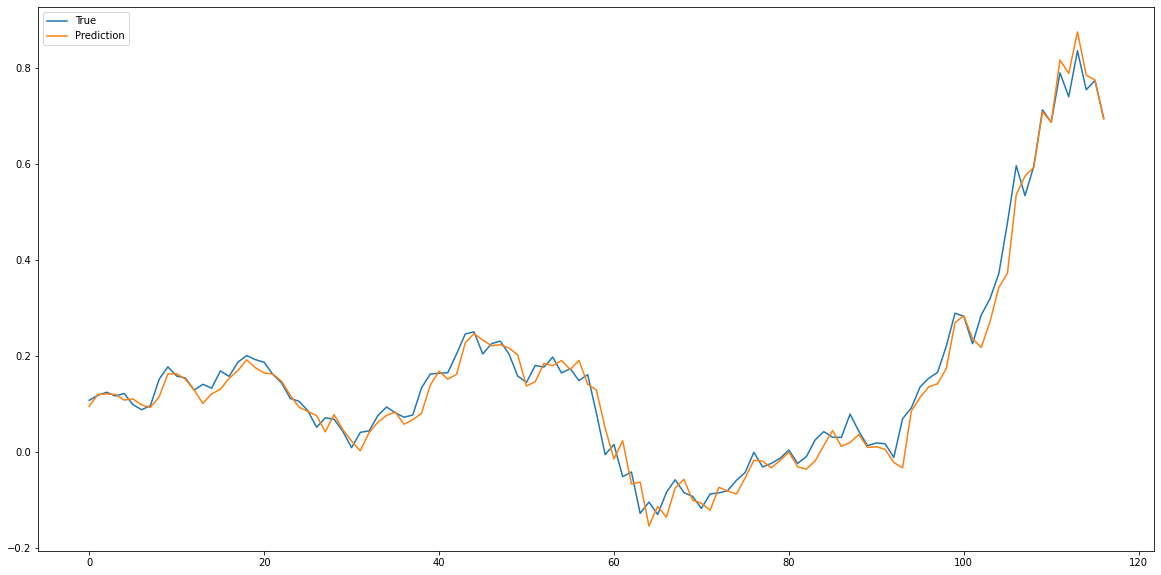

In [0]:
pred = model.predict(x_test) #데스트 데이터 예측

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True') #실제데이터
ax.plot(pred, label='Prediction') #예측데이터
ax.legend()
plt.show()